In [57]:
library(tidyverse)
library(gbm) # Generalized Boosted Regression Models

## Data

For the data, I collected data on about 6,697 Twitter accounts. I believe 4,243 of those accounts are genuine (non-automated) accounts and 2,454 are bots. I then randomly split the data set into a **training** set and a **test** set. In the training data, I made sure there were equal numbers of bots versus non-bots. Since we are not using the test data to build our actual model, it is not important to have equal group sizes in the test data set.

In [6]:
## read in the data (train and test)
train <- readRDS("datasets/twitter/bot/train.rds")
test <- readRDS("datasets/twitter/bot/test.rds")

In [11]:
t(head(train, 2))

user_id,251344965,17621767
name,Videodisc <U+25B3>,Policy Innovations
screen_name,RolexSound,carnegiePI
location,Barcelona,"New York, NY"
description,I'm not a bot . Music . Drawing . Videogames . Sweet Gig.holo.gram booking dani@divined.com https://t.co/jlLMxj37uD <U+30DA><U+30AC><U+30B5><U+30B9>,Policy Innovations is the @carnegiecouncil magazine for #socialinnovation and global ethics. We talk about doers not bystanders. Follow us on Facebook!
url,https://t.co/QnrvTrhJqP,http://t.co/k2DZ1mSSgt
protected,FALSE,FALSE
followers_count,656,7351
friends_count,2154,2177
listed_count,17,520
statuses_count,2058,12428


In [16]:
t(head(test, 2))

user_id,2311776002,472393931
name,Threat Intelligence,Lucy Bailey
screen_name,threatintelbot,LucyBailey_1989
location,Nepal,
description,All About malware,Proud team member of @TiddlyLink ...If I spent any more time on Twitter they'd probably charge me rent :)
url,NA,https://t.co/2tXLGqIukE
protected,FALSE,FALSE
followers_count,1009,29554
friends_count,28,23252
listed_count,393,137
statuses_count,33590,3535


## How many bots and humans are in each dataset?

In [14]:
## bot == 1, not-bot == 0
table(train_bot = train$bot)

train_bot
   0    1 
1604 1604 

In [22]:
## bot == 1, not-bot == 0
table(test_bot = test$bot)

test_bot
   0    1 
2437  799 

## Define my helper functions

In [37]:
# is this a number?
is_num <- function(x) { 
    return(is.numeric(x) | is.integer(x)) 
}

In [38]:
# example output
print(is_num(100))
print(is_num("hello"))

[1] TRUE
[1] FALSE


In [39]:
# extract features for training

extract_features <- function(data) {
    
    # mutate 6 new features
    
    data %>%
        mutate(
            "bio_chars" = nchar(description),
            "verified" = as.integer(verified),
            "years" = as.integer(difftime(Sys.time(), account_created_at, "days")) / 365,
            "tweets_to_followers" = (statuses_count + 1) / (followers_count + 1),
            "statuses_rate" = statuses_count / years,
            "ff_ratio" = (followers_count + 1) / (friends_count + followers_count + 1)
        ) %>%
        select_if(is_num)
}

In [40]:
# example output
extract_features(head(train))

followers_count,friends_count,listed_count,statuses_count,favourites_count,verified,bot,bio_chars,years,tweets_to_followers,statuses_rate,ff_ratio
656,2154,17,2058,2832,0,1,120,7.027397,3.133942,292.8538,0.2337247
7351,2177,520,12428,610,0,1,151,9.243836,1.690560,1344.4635,0.7715395
260,462,11,1449,420,0,1,137,10.756164,5.555556,134.7134,0.3609959
329,548,1,50098,46056,0,1,0,1.287671,151.815152,38905.8936,0.3758542
617,5,31,5491,30,0,1,160,3.852055,8.886731,1425.4730,0.9919743
236,217,47,25066,0,0,1,88,8.350685,105.767932,3001.6699,0.5220264


In [41]:
ftrain <- extract_features(train)
ftest <- extract_features(test)

## Merge datasets

In [50]:
bind_rows(ftrain, ftest) %>%
    group_by(bot) %>%
    summarize_if(is_num, median, na.rm = TRUE)

# combine the dataset then find the median of all numeric columns grouped by bot or not.

bot,followers_count,friends_count,listed_count,statuses_count,favourites_count,verified,bio_chars,years,tweets_to_followers,statuses_rate,ff_ratio
0,1497,338,24,21596,6406,0,67,5.605479,11.811940,4906.197,0.7878366
1,857,249,21,5491,94,0,97,3.994521,8.531579,1499.801,0.6463078


## Train the model

In [59]:
# Generalized Boosted Regression Models

n_trees <- 500

m1 <- gbm(bot ~ ., 
             data = ftrain,
             n.trees = n_trees,
             interaction.depth = 4, 
             cv.folds = 2,
             verbose = FALSE,
             distribution = "bernoulli",
             n.minobsinnode = 10,
             shrinkage = 0.025)

,var,rel.inf
ff_ratio,ff_ratio,32.431327
friends_count,friends_count,25.357232
favourites_count,favourites_count,19.995883
statuses_rate,statuses_rate,4.885199
listed_count,listed_count,4.441326
tweets_to_followers,tweets_to_followers,2.651250
followers_count,followers_count,2.511952
statuses_count,statuses_count,2.390470
bio_chars,bio_chars,2.132458
years,years,1.899008


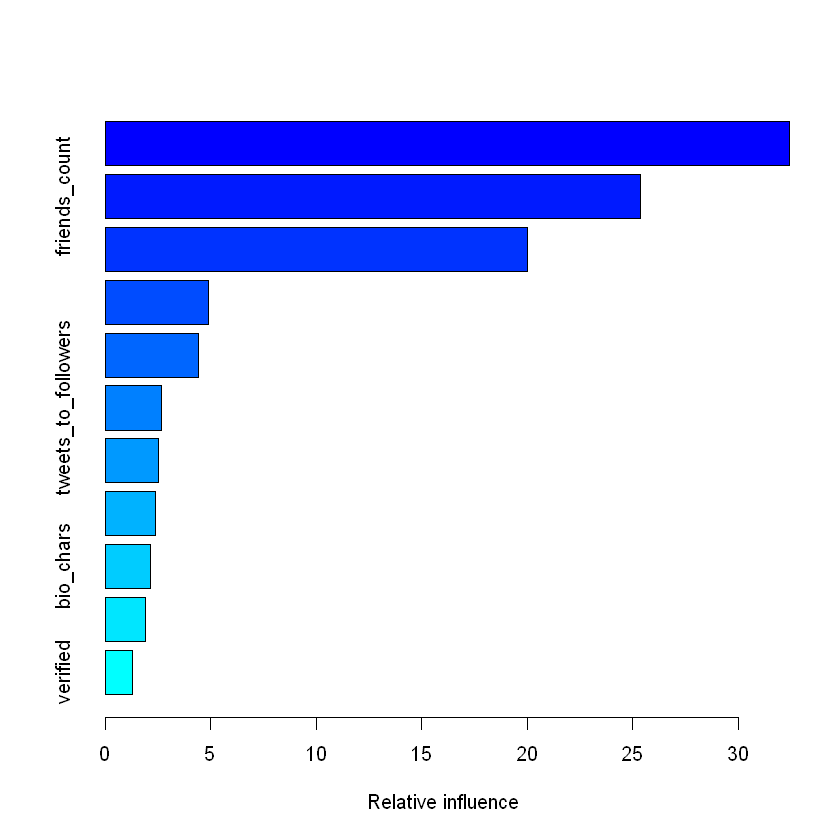

In [62]:
summary(m1, plotit = TRUE)

## Test the model against the training data

In [66]:
ftrain$pred <- predict(m1, n.trees = n_trees, type = "response")

ftrain$pred[0:10]

[1] 0.9314241 0.5924761 0.8671832 0.8837221 0.9829163 0.9562777 0.9795562
 [8] 0.7815243 0.1085095 0.9894583

In [138]:
percent_correct <- function(x) {
    
    # create a 2x2 table of PredictBot and BOT. 
    # CORRECT is defined as pred > 0.5
    x <- table(PredictBot = x$pred > 0.5, bot = x$bot)
    print(x)
    
    print("------------------------")
    
    pc <- round((x[2, 2]) / sum(x[, 2]), 3)
    print(paste("PREDICT BOT & BOT: ", x[2, 2]))
    print(paste("Sum of BOTS: ", sum(x[, 2])))
    print(paste("Percent Correct:", pc * 100))
    pc <- as.character(pc * 100)
    print(paste("The model was", pc, "% accurate when classifying twitter bots."))
    
    print("------------------------")
    
    pc <- round((x[1, 1]) / sum(x[, 1]), 3)
    print(paste("PREDICT NON-BOT & NON-BOT:", x[1, 1]))
    print(paste("Sum of NON-BOTS:", sum(x[, 1])))
    print(paste("Percent Correct:", pc * 100))    
    pc <- as.character(pc * 100)
    print(paste("The model was", pc, "% accurate when clasifying non-bots."))
    
    print("------------------------")
    
    pc <- round((x[1, 1] + x[2, 2]) / sum(c(x[, 1], x[, 2])), 3)
    print(paste("Accurate Predictions:", (x[1, 1] + x[2, 2])))
    print(paste("All Accounts:", sum(c(x[, 1], x[, 2]))))
    pc <- as.character(pc * 100)
    print(paste("Overall, the model was correct", pc, "% of the time."))
}

In [139]:
percent_correct(ftrain)

          bot
PredictBot    0    1
     FALSE 1488  168
     TRUE   116 1436
[1] "------------------------"
[1] "PREDICT BOT & BOT:  1436"
[1] "Sum of BOTS:  1604"
[1] "Percent Correct: 89.5"
[1] "The model was 89.5 % accurate when classifying twitter bots."
[1] "------------------------"
[1] "PREDICT NON-BOT & NON-BOT: 1488"
[1] "Sum of NON-BOTS: 1604"
[1] "Percent Correct: 92.8"
[1] "The model was 92.8 % accurate when clasifying non-bots."
[1] "------------------------"
[1] "Accurate Predictions: 2924"
[1] "All Accounts: 3208"
[1] "Overall, the model was correct 91.1 % of the time."


## Test against our testing dataset

In [140]:
ftest$pred <- predict(m1, newdata = ftest, n.trees = n_trees, type = "response")

In [142]:
percent_correct(ftest)

          bot
PredictBot    0    1
     FALSE 2169  102
     TRUE   268  697
[1] "------------------------"
[1] "PREDICT BOT & BOT:  697"
[1] "Sum of BOTS:  799"
[1] "Percent Correct: 87.2"
[1] "The model was 87.2 % accurate when classifying twitter bots."
[1] "------------------------"
[1] "PREDICT NON-BOT & NON-BOT: 2169"
[1] "Sum of NON-BOTS: 2437"
[1] "Percent Correct: 89"
[1] "The model was 89 % accurate when clasifying non-bots."
[1] "------------------------"
[1] "Accurate Predictions: 2866"
[1] "All Accounts: 3236"
[1] "Overall, the model was correct 88.6 % of the time."


# Not too shabby